In [5]:
import numpy as np
import scipy as sp

import matplotlib.pyplot as plt
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True) #Want to be able to use tex in the plot labels
%matplotlib inline
import seaborn

seaborn.set_style('ticks')
seaborn.set_color_codes()

### Parameter Estimation with MCMC

In the last notebook, we looked at how to generate samples from a particular distribution, given knowledge of the distribution. This is not what I, and many others, typically use MCMC for - rather, we look to use observed data to learn about the parameters of an *unknown* distribution.

In this example, the distribution is, in fact, known - we will use the same student t distribution we have been working with. First, we will generate our 'data,' which will be a set of samples from this known distribution.


In [14]:
def dist(x):                  #x is read in to this function
    nu = 3.                   #the parameters of the distribution are fixed
    sigma = 1.
    mu = 2.
    
    norm = np.sqrt(nu*np.pi*sigma*sigma)
    ratio = sp.special.gamma((nu+1.)/2.)/sp.special.gamma(nu/2.)
    
    px = ratio*(1.+(1./nu)*((x-mu)**2)/sigma)**(-(nu+1.)/2.)/norm
    
    return px

def tdist(x,mu,nu,sigma):                  #x is read in to this function 
    norm = np.sqrt(nu*np.pi*sigma*sigma)
    ratio = sp.special.gamma((nu+1.)/2.)/sp.special.gamma(nu/2.)
    
    px = ratio*(1.+(1./nu)*((x-mu)**2)/sigma)**(-(nu+1.)/2.)/norm
    
    return px

In [7]:
def prop(x,alpha):          #needs current location (x), and variance of Gaussian (alpha)
    return np.random.normal(loc=x,scale=alpha)
    

In [11]:
Nstep = 2000                #number of iterations for which to run the chain
xstart = 2.                 #gotta start somewhere
alpha = 0.87                #variance for prop. dist.

data = []              #empty list to store the samples
Nacc = 0.                   #counter for accepted jumps
x = xstart
for i in range(Nstep):      #for loop is the actual sampling process
    lx = dist(x)            #likelihood at x 
    y = prop(x,alpha)       #propose a new value - y
    ly = dist(y)            #likelihood at y
    r = np.random.rand()
    if ly/lx > r:           #compare the Hastings ratio (in this case just the likelihood ratio) to random number r.
                            #Note that we haven't explicitly calcualted a prior value - this is fine if the prior is
                            #uniform in all parameters. It will just cancel out of the Hastings ratio in this case.
        x = y               #if H>r, accept the jump.
        Nacc += 1.          #iterate the acceptance counter
    data.append(x)     #whether the jump was accepted or not, the current value of x is a new sample.


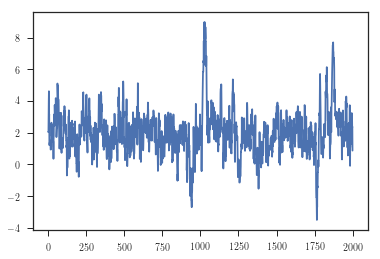

In [13]:
plt.plot(data)

Now we're turning the problem around - $\{x\}$ is now $\{ d \}$, the data, and the model parameters are $\mu$, $\nu$, and $\sigma$. We now need to write a new likelihood
\begin{equation}
p(d|\mu,\nu,\sigma) = \prod_i \frac{\Gamma((\nu +1)/2}{\sqrt{\nu \pi \sigma^2}\Gamma(\nu/2)} \left(1 +\frac{1}{\nu} \left( \frac{d_i-\mu}{\sigma} \right)^2 \right),
\end{equation}
which is just a product over the observations of the likelihood of observing each point given the parameters.

So, as before, we will need to define a likelihood, prior, and proposal distribution. We will use a simple prior distribution that is uniform between -10 and 10 for all three of the parameters.


In [28]:
def like(d,x):
    mu = x[0]
    sigma = x[1]
    nu = x[2]
    
    likevals = tdist(d,mu,nu,sigma)
    loglike = np.log(likevals)        #For numerical stability, we will work with the *log* likelihood
    
    return np.sum(loglike)  

In [30]:
def prior(x):
    mu = x[0]
    sigma = x[1]
    nu = x[2]
    
    if mu> 10. or mu<-10.:
        return -np.inf
    if sigma>10. or sigma<-10:
        return -np.inf
    if nu>10. or nu<-10.:
        return -np.inf
    
    return 0.